# Current through a molecule

In this notebook I will investigate:
- how current passes through a molecule under some electronic potential, effects of lead non-additivity
- how photocurrent is induced when the molecule is incident to a (hot) thermal electromagnetic environment
- The effects of lead and phonon non-additivity on photocurrent


In [30]:
%matplotlib inline

import time
import numpy as np

import matplotlib.pyplot as plt
import qutip as qt
import scipy as sp


import fermionic_leads as fl

import UD_liouv as RC
import driving_liouv as EM

import phonon_weak_coupling as WC

from qutip import ket, basis, sigmam, sigmap, spre, sprepost, spost, destroy, mesolve, tensor, qeye
from numpy import pi, linspace
from fermionic_leads import non_additive_lead_dissipator, additive_lead_dissipator, current_from_L
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard, J_multipolar
from utils import ground_and_excited_states, initialise_TLS

## First: current-voltage diagrams in absence of phonons

In [33]:

kB = 0.695
d = destroy(2)
ddag = d.dag()

sigma = ket([0])*ket([1]).dag()

E = basis(2,1)*basis(2,1).dag()
G = basis(2,0)*basis(2,0).dag()

eps = 1000
mu = 100
T = 100
Gamma_l = 1.
H = eps*E

reload(fl)

def simple_current_voltage(eps, T_L, width_L, pos_L, T_R, mu_R, width_R, pos_R, mu_L_max =2000):
    mu_Ls = np. linspace(0, mu_L_max, 100)
    currents = []
    for mu_L in mu_Ls:
        L_L = non_additive_lead_dissipator(H, d, eps, T_L, mu_L, Gamma, width_L, pos_L, J_underdamped)
        L_R = non_additive_lead_dissipator(H, d, eps, T_R, mu_R, Gamma, width_R, pos_R, J_underdamped)
        currents.append(current_from_L(H, L_L+L_R, L_R, E))
    return mu_Ls-mu_R, currents

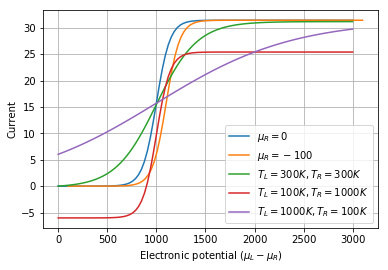

In [32]:

mu_L_max = 3000
width = eps
pos= eps
v1, c1 = simple_current_voltage(eps, T, width, pos, T, 0, width, pos, mu_L_max =mu_L_max)
v2, c2 = simple_current_voltage(eps, T, width, pos, T, -100, width, pos, mu_L_max =mu_L_max)
v3, c3 = simple_current_voltage(eps, 300., width, pos, 300., 0, width, pos, mu_L_max =mu_L_max)
v4, c4 = simple_current_voltage(eps, 100., width, pos, 1000., 0, width, pos, mu_L_max =mu_L_max) 
v5, c5 = simple_current_voltage(eps, 1000., width, pos, 100., 0, width, pos, mu_L_max =mu_L_max)
plt.plot(v1, c1, label='$\mu_R=0$')
plt.plot(v2, c2, label='$\mu_R=-100$')
plt.plot(v3, c3, label='$T_L=300K, T_R=300K$')
plt.plot(v4, c4, label='$T_L=100K, T_R=1000K$')
plt.plot(v5, c5, label='$T_L=1000K, T_R=100K$')
plt.xlabel("Electronic potential ($\mu_L-\mu_R$)")
plt.ylabel("Current")
plt.grid()
plt.legend()
plt.show()

The normal current-voltage relations are reproduced:
- A saddle-point at the TLS transition energy
- A shift in the x-axis as the bias window spans different sections/proportions of the TLS energy gap
- Squashed in y-direction for increasing temperature - equilibrium population is higher so needs higher gradient to move - current in high-bias limit is temperature independent
- If there is a thermal gradient against current, there can be backward thermoelectric current at low enough bias (?)
- Opposite is true for positive thermal gradient, though the overall current is lower in high-bias regime

## Phonons and leads

Here I'll investigate current-voltage relations when including phonons. The exact same plots as above but with a single mode with a couple of different parameters.

In [95]:
reload(fl)
Gamma_l = 1.
ti = time.time()
T_ph = 100.
N = 20
T_EM=0.
J_EM=J_multipolar
init_sys = G
init_RC = 0
Gamma, w0, alpha_ph, Gamma_EM = 10., 50., 100./pi, 1.
d_RC = tensor(d, qeye(N))
E_RC = tensor(E, qeye(N))
L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _, = RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 
                                                         N, silent=True)

#timelist = np.linspace(0, 3/Gamma_EM, 360)
#L = [L_nrwa, L_esa]

#expects = [tensor(E*E.dag(), qeye(N)), tensor(E*G.dag()+G*E.dag(), qeye(N))]
#rho_0 = initialise_TLS(init_sys, init_RC, H_RC.eigenstates()[1], w0, T_ph, H_RC=H_RC)

opts = qt.Options(nsteps=1000)
T_L, T_R, mu_R, mu_L = 100, 100.,0.,1000.
width = eps
pos = eps
L_L = non_additive_lead_dissipator(H_RC, d_RC, eps, T_L, mu_L, Gamma_l, 
                                   width, pos, J_underdamped)
L_R = non_additive_lead_dissipator(H_RC, d_RC, eps, T_R, mu_R, Gamma_l,
                                   width, pos, J_underdamped)
L_leads = L_L + L_R
"""DATA_full = mesolve(H_RC, rho_0, timelist, [L_RC+L_leads+L_full], 
                              expects, options=opts)
DATA_add = mesolve(H_RC, rho_0, timelist, [L_RC+L_leads+L_add], 
                              expects, options=opts)
plt.plot(timelist, DATA_full.expect[0])
plt.plot(timelist, DATA_add.expect[0])
plt.show()
"""

def current_vs_voltage_with_phonons(eps=1000., T_ph=77, Gamma=10., w0=50., alpha_ph=10., N=10, 
                                    Gamma_L=0.5, T_L=77., width_L=1000., pos_L=1000.,
                                    Gamma_R=0.5, T_R=77., mu_R=0., width_R=1000., pos_R=1000.):
    T_L = T_ph
    T_R = T_ph
    pos_L = pos_R = eps
    ti = time.time()
    mu_Ls = np. linspace(0, 30.*w0, 70)
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    currents = []
    d_RC = tensor(d, qeye(N))
    E_RC = tensor(E, qeye(N))
    L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _, = RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 
                                                         N, silent=True)
    
    #timelist = np.linspace(0, 3/Gamma_EM, 360)
    for i, mu_L in enumerate(mu_Ls):
        L_L, L_R = fl.L_R_lead_dissipators(H_RC, d_RC, eps, T_L, mu_L, Gamma_L, width_L, pos_L,
                                           T_R, mu_R, Gamma_R, width_R, pos_R)
        currents.append(current_from_L(H_RC, L_RC+L_L+L_R, L_R, E_RC))
        if (i%10)==0:
            print 100*(float(i)/len(mu_Ls)), "% complete"
    print "Took {} seconds.".format(time.time()-ti)
    return mu_Ls-mu_R, currents

In [98]:

#v0, c0 = simple_current_voltage(1000, 77, width, pos, 77, 0, width, pos, mu_L_max =2000.)
#v11, c11 = current_vs_voltage_with_phonons(eps=1000., T_ph=77, Gamma=10., w0=50., alpha_ph=1., N=5)
w_RC = 0.695*100

v1, c1 = current_vs_voltage_with_phonons(eps=100., T_ph=30., Gamma=sqrt(0.5)*w_RC**(3/2.), w0=w_RC, alpha_ph=25., N=13,
                                        width_L=w_RC*10, width_R=w_RC*10.)
v2, c2 = current_vs_voltage_with_phonons(eps=100., T_ph=30., Gamma=sqrt(5)*w_RC**(3/2.), w0=w_RC, alpha_ph=25., N=13,
                                        width_L=w_RC*10, width_R=w_RC*10)
v3, c3 = current_vs_voltage_with_phonons(eps=100., T_ph=30., Gamma=sqrt(5)*w_RC**(3/2.), w0=w_RC, alpha_ph=75., N=13,
                                        width_L=w_RC*10, width_R=w_RC*10)
#v2, c2 = current_vs_voltage_with_phonons(eps=1000., T_ph=77, Gamma=10., w0=50., alpha_ph=10., N=10)
#v3, c3 = current_vs_voltage_with_phonons(eps=1000., T_ph=77, Gamma=10., w0=50., alpha_ph=50., N=17)
#v4, c4 = current_vs_voltage_with_phonons(eps=1000., T_ph=77, Gamma=25., w0=50., alpha_ph=50., N=17)
#v5, c5 = current_vs_voltage_with_phonons(eps=1000., T_ph=77, Gamma=10., w0=100., alpha_ph=50., N=10)


RC would need 1.43884892086 states to fill electronic gap.
0.0 % complete
14.2857142857 % complete
28.5714285714 % complete
42.8571428571 % complete
57.1428571429 % complete
71.4285714286 % complete
85.7142857143 % complete
Took 132.830701113 seconds.
RC would need 1.43884892086 states to fill electronic gap.
0.0 % complete
14.2857142857 % complete
28.5714285714 % complete
42.8571428571 % complete
57.1428571429 % complete
71.4285714286 % complete
85.7142857143 % complete
Took 131.810868025 seconds.
RC would need 1.43884892086 states to fill electronic gap.
0.0 % complete
14.2857142857 % complete
28.5714285714 % complete
42.8571428571 % complete
57.1428571429 % complete
71.4285714286 % complete
85.7142857143 % complete
Took 140.901376963 seconds.


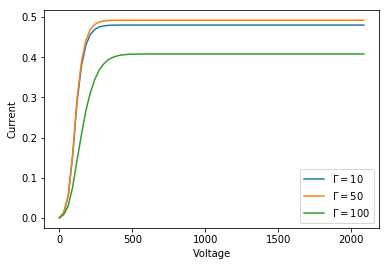

In [100]:
#plt.plot(v0, c0, label=r'$\alpha=0$')
#plt.plot(v11, c11, label=r'$\alpha=1, \omega_0=50$')
plt.plot(v1, c1, label=r'$\Gamma=10$')
plt.plot(v2, c2, label=r'$\Gamma=50$')
plt.plot(v3, c3, label=r'$\Gamma=100$')
"""
plt.plot(v4, c4, label=r'$\alpha=50, \Gamma=25$')
plt.plot(v5, c5, label=r'$\alpha=50, \omega_0=100$')"""
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.legend()
plt.show()

In [55]:
reload(fl)
reload(RC)
def current_vs_phonon_coupling(eps, T_ph, Gamma, w0, N=10,
                               gamma_L=1., T_L=77., mu_L=1000., width_L=1000., pos_L=1000.,
                               gamma_R=1., T_R=77., mu_R=0., width_R=1000., pos_R=1000.):
    ti = time.time()
    alpha_prop = np. linspace(0, 1., 50)
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    currents_add = []
    currents_nonadd = []
    d_RC = tensor(d, qeye(N))
    E_RC = tensor(E, qeye(N))
    #timelist = np.linspace(0, 3/Gamma_EM, 360)
    for i, alphap in enumerate(alpha_prop):
        alpha_ph = alphap*eps/pi
        L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _, = RC.RC_function_UD(d, eps, T_ph, Gamma, w0, alpha_ph, 
                                                         N, silent=True)
        L_Ladd = additive_lead_dissipator(eps, d_RC, T_L, mu_L, Gamma_l)
        L_Radd = additive_lead_dissipator(eps, d_RC, T_R, mu_R, Gamma_l)
        L_Lfull, L_Rfull = fl.L_R_lead_dissipators(H_RC, d_RC, eps, 
                                                   T_L, mu_L, gamma_L, width_L, pos_L,
                                                   T_R, mu_R, gamma_R, width_L, pos_L)
        currents_add.append(current_from_L(H_RC, L_RC+L_Ladd+L_Radd, L_Radd, E_RC))
        currents_nonadd.append(current_from_L(H_RC, L_RC+L_Lfull+L_Rfull, L_Rfull, E_RC))
        if (i%10)==0:
            print 100*(float(i)/len(alpha_prop)), "% complete"
    print "Took {} seconds.".format(time.time()-ti)
    return alpha_prop, currents_add, currents_nonadd
N = 10
a_prop1, c1a, c1na = current_vs_phonon_coupling(1000., 77., 10, 50., N=2*N, T_L=77., 
                                                  T_R=77., mu_R=0., mu_L=1000.)
a_prop2, c2a, c2na = current_vs_phonon_coupling(1000., 77., 10, 100., N=N, T_L=77., 
                                                  T_R=77., mu_R=0., mu_L=1000.)
a_prop2, c3a, c3na = current_vs_phonon_coupling(1000., 77., 10, 100., N=N, T_L=77., 
                                                  T_R=77., mu_R=0., mu_L=1500.)

RC would need 20.0 states to fill electronic gap.
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete
Took 279.189440966 seconds.
RC would need 10.0 states to fill electronic gap.
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete
Took 76.3821949959 seconds.
RC would need 10.0 states to fill electronic gap.
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete
Took 65.403853178 seconds.


In [78]:
(0.695*77)/1000.

0.05351499999999999

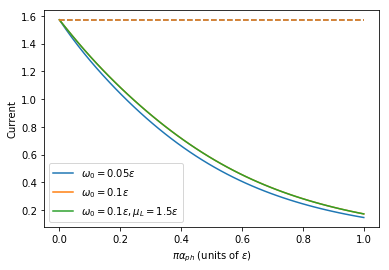

In [56]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(a_prop1, c1na, label=r'$\omega_0=0.05\epsilon$', color=colors[0])
plt.plot(a_prop1, c1a, color=colors[0], ls='dashed')
plt.plot(a_prop2, c2na, label=r'$\omega_0=0.1\epsilon$', color=colors[1])
plt.plot(a_prop2, c2na, label=r'$\omega_0=0.1\epsilon, \mu_L=1.5\epsilon$ ', color=colors[2])
plt.plot(a_prop2, c2a, color=colors[1], ls='dashed')
plt.legend()
plt.xlabel(r"$\pi\alpha_{ph}$ (units of $\epsilon$)")
plt.ylabel("Current")

From the above analysis, we can see:
- "subband" behaviour is not seen, i.e. when the voltage gap includes more vibration levels, this does not lead to enhanced transport. I would have thought it is a combination of the electron-phonon coupling $\sigma_z$ not causing transitions and the weak-coupling approximation in the leads.
- Higher phonon coupling leads to a decrease in current, presumably due to the population relaxing down the some higher lying vibronic state rather than the electronic ground so less energy is available to be extracted?
- Additive lead coupling sees no phonon-coupling dependence on current.
- Lower frequency modes lead to slightly lower currents - either a convergence problem or something to do with the way energy is distributed (lower) when you have more states to occupy.

## Photocurrent

RC would need 20.0 states to fill electronic gap.
0.0 % complete
33.3333333333 % complete
66.6666666667 % complete
Took 0.414345026016 seconds.
RC would need 20.0 states to fill electronic gap.
0.0 % complete
33.3333333333 % complete
66.6666666667 % complete
Took 0.395993947983 seconds.
RC would need 20.0 states to fill electronic gap.
0.0 % complete
33.3333333333 % complete
66.6666666667 % complete
Took 0.693045139313 seconds.
RC would need 20.0 states to fill electronic gap.
0.0 % complete
33.3333333333 % complete
66.6666666667 % complete
Took 0.307703018188 seconds.
RC would need 20.0 states to fill electronic gap.
0.0 % complete
33.3333333333 % complete
66.6666666667 % complete
Took 0.306739091873 seconds.


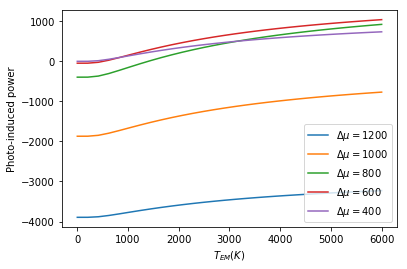

In [58]:
def photopower_vs_T_EM(eps, Gamma_EM=1.,
                       Gamma_L=1., T_L=77., mu_L=100.,  width_L=1000., pos_L=1000.,
                       Gamma_R=1., T_R=77., mu_R=900., width_R=1000., pos_R=1000.):
    ti = time.time()
    T_EM_list = np. linspace(0, 6000., 30)
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    currents = []
    
    #timelist = np.linspace(0, 3/Gamma_EM, 360)
    for i, T_EM in enumerate(T_EM_list):

        L_EM = EM.L_EM_lindblad(eps, d, Gamma_EM, T_EM, J_EM, silent=True)
        L_L = additive_lead_dissipator(eps, d, T_L, mu_L, Gamma_L)
        L_R = additive_lead_dissipator(eps, d, T_R, mu_R, Gamma_R)
        currents.append(current_from_L(H, L_EM+L_L+L_R, L_R, E))
        if (i%10)==0:
            print 100*(float(i)/len(T_EM_list)), "% complete"
    print "Took {} seconds.".format(time.time()-ti)
    return T_EM_list, (mu_R-mu_L)*np.array(currents)

T = 77.
g_ = 1.
T1, P1 = photopower_vs_T_EM(eps, T_L=T, T_R=T,
                         mu_L=-100., mu_R=1100., Gamma_EM=3.*g_, Gamma_L=g_)
T2, P2 = photopower_vs_T_EM(eps, T_L=T, T_R=T,
                         mu_L=0., mu_R=1000., Gamma_EM=3.*g_, Gamma_L=g_)
T3, P3 = photopower_vs_T_EM(eps, T_L=T, T_R=T,
                         mu_L=100., mu_R=900., Gamma_EM=3.*g_, Gamma_L=g_)
T4, P4 = photopower_vs_T_EM(eps, T_L=T, T_R=T,
                         mu_L=200., mu_R=800., Gamma_EM=3.*g_, Gamma_L=g_)
T5, P5 = photopower_vs_T_EM(eps, T_L=T, T_R=T,
                         mu_L=300., mu_R=700., Gamma_EM=3.*g_, Gamma_L=g_)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(T1, P1, label=r'$\Delta\mu=1200$', color=colors[0])
plt.plot(T1, P2, label=r'$\Delta\mu=1000$', color=colors[1])
plt.plot(T1, P3, label=r'$\Delta\mu=800$', color=colors[2])
plt.plot(T1, P4, label=r'$\Delta\mu=600$', color=colors[3])
plt.plot(T1, P5, label=r'$\Delta\mu=400$', color=colors[4])
plt.legend()
plt.xlabel(r"$T_{EM} (K)$")
plt.ylabel("Photo-induced power")

In [59]:
from numpy import sqrt
from fermionic_leads import rate_up, rate_down
import utils as ut

def hopping_model(llplus_gap, lzero_gap, Gamma_EM=5., T_EM=6000.,
                  Gamma_L=1., T_L=77., mu_L=100., 
                  Gamma_R=1., T_R=77., mu_R=900.):
    lumoplus = basis(3, 2)
    lumo = basis(3, 1)
    zero = basis(3, 0)
    H = llplus_gap*lumoplus*lumoplus.dag() + 0*lumo*lumo.dag() + -lzero_gap*zero*zero.dag()
    col_L = lumo*zero.dag()
    col_R = lumoplus*zero.dag()
    col_EM = lumoplus*lumo.dag()
    # Check 
    L_L = rate_down(lzero_gap, T_L, mu_L, Gamma_L)*qt.lindblad_dissipator(col_EM)
    L_L += rate_up(lzero_gap, T_L, mu_L, Gamma_L)*qt.lindblad_dissipator(col_EM.dag())
    L_R = rate_down(llplus_gap+lzero_gap, T_R, mu_R, Gamma_R)*qt.lindblad_dissipator(col_EM)
    L_R += rate_up(llplus_gap+lzero_gap, T_R, mu_R, Gamma_R)*qt.lindblad_dissipator(col_EM.dag())
    
    n_EM = ut.Occupation(llplus_gap, T_EM)
    L_EM = pi*Gamma_EM*((1+n_EM)*qt.lindblad_dissipator(col_EM)+n_EM*qt.lindblad_dissipator(col_EM.dag()))
    return H, L_L, L_R, L_EM


def current_from_L(H, L_full, L_track, n):
    rho_ss = qt.steadystate(H, [L_full])
    time_dependence = (qt.vector_to_operator(L_track*qt.operator_to_vector(rho_ss))*n).tr()
    return -time_dependence


H, L_L, L_R, L_EM = hopping_model(1000., 100., Gamma_EM=1., T_EM=6000.,
                                    Gamma_L=1., T_L=77., mu_L=3000., 
                                    Gamma_R=1., T_R=77., mu_R=0.)
rho_ss = qt.steadystate(H, [L_L+L_R+L_EM])
lumoplus = basis(3, 2)
print current_from_L(H, L_L+L_R+L_EM, L_R, lumoplus*lumoplus.dag())
print rho_ss

TypeError: rate_down() takes exactly 7 arguments (4 given)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.        ]
 [ 0.          0.43349726  0.        ]
 [ 0.          0.          0.56650274]] Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.]
 [ 0.]
 [ 1.]]


In [46]:
def photocurrent_vs_phonon_coupling(eps, T_ph, Gamma, w0, T_EM=5800., N=10, 
                                    T_L=77., T_R=77., mu_L=100., mu_R=900.,
                                    Gamma_EM=1.):
    ti = time.time()
    alpha_prop = np. linspace(0, 1., 50)
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    currents_add = []
    currents_nonadd = []
    d_RC = tensor(d, qeye(N))
    E_RC = tensor(E, qeye(N))
    
    #timelist = np.linspace(0, 3/Gamma_EM, 360)
    for i, alphap in enumerate(alpha_prop):
        alpha_ph = alphap*eps/pi
        L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _, = RC.RC_function_UD(d, eps, T_ph, Gamma, w0, alpha_ph, 
                                                         N, silent=True)
        L_EM_add = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J_EM, silent=True)
        L_EM_full = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
        L_L_add = additive_lead_dissipator(eps, d_RC, T_L, mu_L, Gamma_l)
        L_R_add = additive_lead_dissipator(eps, d_RC, T_R, mu_R, Gamma_l)
        L_L_full, L_R_full = fl.L_R_lead_dissipators(H_RC, d_RC, eps, T_L, mu_L, Gamma_l, T_R, mu_R, Gamma_l)
        currents_add.append(current_from_L(H_RC, L_RC+L_EM_add+L_L_add+L_R_add, L_R_add, E_RC))
        currents_nonadd.append(current_from_L(H_RC, L_RC+L_EM_full+L_L_full+L_R_full, L_R_full, E_RC))
        if (i%10)==0:
            print 100*(float(i)/len(alpha_prop)), "% complete"
    print "Took {} seconds.".format(time.time()-ti)
    return alpha_prop, currents_add, currents_nonadd

# assume that the molecule and the leads are in thermal equilibrium
T = 77.
ap, pca1, pcna1 = photocurrent_vs_phonon_coupling(1000., T, 10., 100., T_EM=5800., N=10, 
                                    T_L=T, T_R=T, mu_R=900., mu_L=100.,
                                    Gamma_EM=1.)
T = 100.
ap, pca2, pcna2 = photocurrent_vs_phonon_coupling(1000., T, 10., 100., T_EM=5800., N=10, 
                                    T_L=T, T_R=T, mu_R=900., mu_L=100.,
                                    Gamma_EM=1.)
T = 150.
ap, pca3, pcna3 = photocurrent_vs_phonon_coupling(1000., 150., 10., 100., T_EM=5800., N=10, 
                                    T_L=T, T_R=T, mu_R=900., mu_L=100.,
                                    Gamma_EM=1.)

RC would need 10.0 states to fill electronic gap.
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete
Took 81.8650860786 seconds.
RC would need 10.0 states to fill electronic gap.
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete
Took 78.517111063 seconds.
RC would need 10.0 states to fill electronic gap.
0.0 % complete
20.0 % complete
40.0 % complete
60.0 % complete
80.0 % complete
Took 78.7262010574 seconds.


In [41]:
0.695*150./1000, 0.695*77/1000.

(0.10424999999999998, 0.05351499999999999)

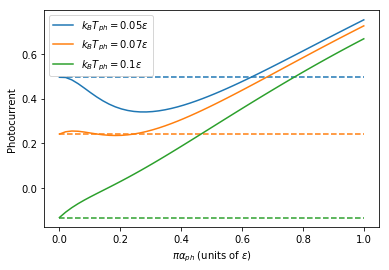

In [49]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(ap, pcna1, label=r'$k_B T_{ph}=0.05\epsilon$', color=colors[0])
plt.plot(ap, pca1, color=colors[0], ls='dashed')
plt.plot(ap, pcna2, label=r'$k_B T_{ph}=0.07\epsilon$', color=colors[1])
plt.plot(ap, pca2, color=colors[1], ls='dashed')
plt.plot(ap, pcna3, label=r'$k_B T_{ph}=0.1\epsilon$', color=colors[2])
plt.plot(ap, pca3, color=colors[2], ls='dashed')
plt.legend()
plt.xlabel(r"$\pi\alpha_{ph}$ (units of $\epsilon$)")
plt.ylabel("Photocurrent")